# Let's compare the models

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
tfk.mixed_precision.set_global_policy("mixed_float16")

tf.random.set_seed(42)

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tfk.__version__)
print("Is GPU detected: ", len(tf.config.list_physical_devices('GPU'))>0)

2025-02-06 15:49:22.456909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 15:49:22.728180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738853362.833286    4146 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738853362.861093    4146 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 15:49:23.114485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Tensorflow version:  2.18.0
Keras version:  3.8.0
Is GPU detected:  True


## Load dataset

In [2]:
data = np.load('./balanced_masked_slices_radiomics.npz')
full_slices = data['full_slices']
segmented_full_slices = data['segmented_full_slices']
radiomics = data['radiomics']
tumor_classes = data['labels']

# Normalize images
full_slices = full_slices / 255.0
segmented_full_slices = segmented_full_slices / 255.0


print("segmented_full_slices shape: ", segmented_full_slices.shape)
print("tumor_classes shape: ", tumor_classes.shape)
print("radiomics shape: ", radiomics.shape)

segmented_full_slices shape:  (4542, 512, 512, 1)
tumor_classes shape:  (4542, 5)
radiomics shape:  (4542, 93, 2)


In [3]:
radiomics_feature_names = radiomics[0, :, 0]
radiomics_features = radiomics[:, :, 1]

In [4]:
# Radiomics features preparation
import pickle as pk

data_transform = pk.load(open("standard_scaler_and_pca.pkl",'rb')) 
radiomics_features_PCA = data_transform.transform(radiomics_features)

## Confusion matrices

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def plot_confusion_matrix(ax, predictions, true_labels):
    classes = [1, 2, 3, 4, 5]

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Combine numbers and percentages into a single string for annotation
    annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    # Plot the confusion matrix
    ax.set_xlabel('Predicted labels') # why no work :(
    ax.set_ylabel('True labels') # why no work :(
    sns.heatmap(cm, annot=annot, fmt=".4", xticklabels=classes, yticklabels=classes, cmap='Blues', ax=ax)

In [5]:
full_slice_model = tfk.models.load_model("./models/Multiclass_RadioactiveMedusa_normal.keras")
segmented_model = tfk.models.load_model("./models/Multiclass_RadioactiveMedusa_segmented.keras")

I0000 00:00:1738853389.052000    4146 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13934 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
full_full_preds = full_slice_model.predict([full_slices, radiomics_features_PCA])
full_seg_preds = full_slice_model.predict([segmented_full_slices, radiomics_features_PCA])

seg_full_preds = segmented_model.predict([full_slices, radiomics_features_PCA])
seg_seg_preds = segmented_model.predict([segmented_full_slices, radiomics_features_PCA])

2025-02-06 15:49:59.617258: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1738853399.621089    4260 service.cc:148] XLA service 0x70fb100158e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738853399.621323    4260 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-02-06 15:49:59.638864: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738853399.684000    4260 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-06 15:50:04.247834: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,256,256,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,256,256,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), wi

  1/142 ━━━━━━━━━━━━━━━━━━━━ 53:48 23s/step

I0000 00:00:1738853422.288080    4260 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

2025-02-06 15:50:44.357523: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[30,256,256,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[30,256,256,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-06 15:50:46.064204: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.706781175s
Trying algorithm eng0{} for conv (f16[30,256,256,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[30,256,256,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_con

142/142 ━━━━━━━━━━━━━━━━━━━━ 61s 273ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step


In [7]:
true_classes = np.argmax(tumor_classes, axis=-1)

predictions = [
    np.argmax(full_full_preds, axis=-1), 
    np.argmax(full_seg_preds, axis=-1), 
    np.argmax(seg_full_preds, axis=-1), 
    np.argmax(seg_seg_preds, axis=-1)
]

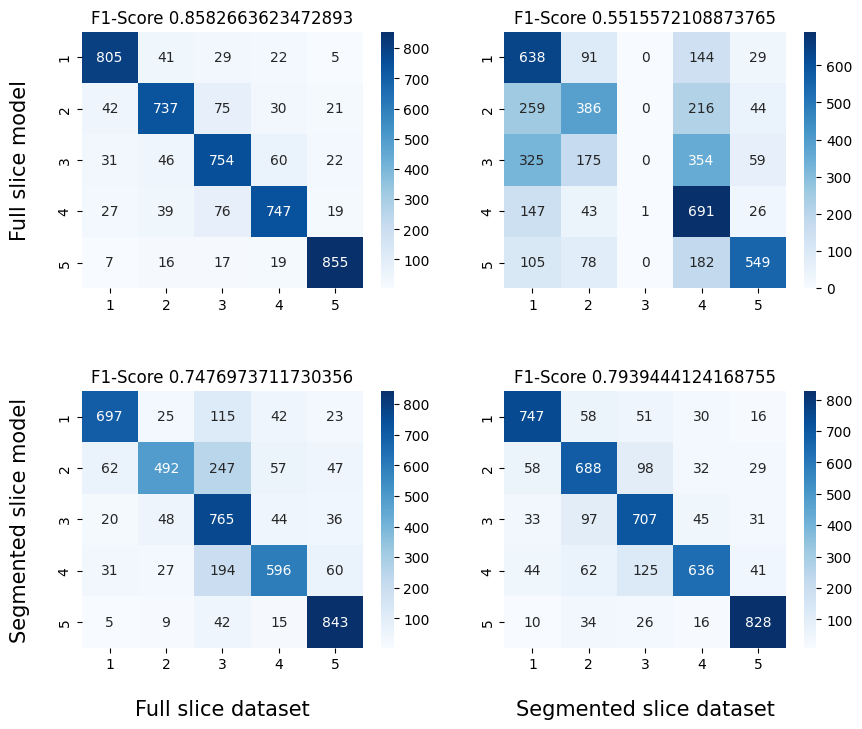

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plt.subplots_adjust(wspace=0.2, hspace=0.4)

for ax, preds in zip(axs.flat, predictions):
    ax.set_xlabel(None, size=15, labelpad=20)
    ax.set_ylabel(None, size=15, labelpad=20)
    ax.set_title(f"F1-Score {f1_score(preds, true_classes, average='weighted')}")
    plot_confusion_matrix(ax, preds, true_classes)

_ = plt.setp(axs[1, 0], xlabel='Full slice dataset')
_ = plt.setp(axs[1, 1], xlabel='Segmented slice dataset')
_ = plt.setp(axs[0, 0], ylabel='Full slice model')
_ = plt.setp(axs[1, 0], ylabel='Segmented slice model')

The model trained on full slices performs generally worse than the model trained on segmented slices. Moreover, the second model is able to perform very well on full slices even then it hasn't been trained using complete images but only segmented ones.

## CAM Analysis

The previous results points to a difference in how the two models look at images and extract features from them. The second model, the one that was train to recognize features only in a specific part of the image, is performing better than the one who learned from the whole images. Let's check which part of the images are looked by the models to make predictions.

In [12]:

# from https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tfk.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    import matplotlib as mpl

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tfk.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tfk.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tfk.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img

In [23]:
TEST_IMAGE_IDX = 0 # 130 for correct detection and 1444 for comparison

test_image = np.expand_dims(full_slices[TEST_IMAGE_IDX], axis=0)
test_image_radiomics = np.expand_dims(radiomics_features_PCA[TEST_IMAGE_IDX], axis=0)

# Remove last layer's softmax
full_slice_model.layers[-1].activation = None
segmented_model.layers[-1].activation = None

In [24]:
heatmap = make_gradcam_heatmap([test_image, test_image_radiomics], full_slice_model, last_conv_layer_name="spatial_dropout_3")
img1 = display_gradcam(data['full_slices'][TEST_IMAGE_IDX], heatmap=heatmap, cam_path=f"./cams/cam_{TEST_IMAGE_IDX}.png", alpha=0.8)

heatmap = make_gradcam_heatmap([test_image, test_image_radiomics], segmented_model, last_conv_layer_name="spatial_dropout_3")
img2 = display_gradcam(data['full_slices'][TEST_IMAGE_IDX], heatmap=heatmap, cam_path=f"./cams/segcam_{TEST_IMAGE_IDX}.png", alpha=0.8)

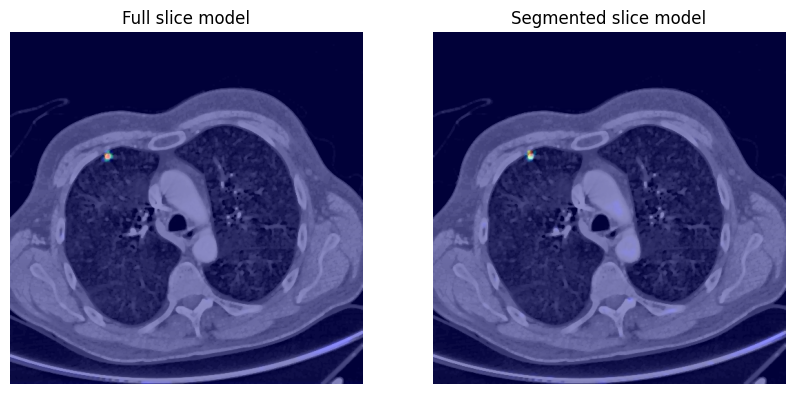

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
for ax, img in zip(axes.flatten(), [img1, img2]):
    ax.imshow(img)
    ax.set_axis_off()

_ = axes[0].set_title("Full slice model")
_ = axes[1].set_title("Segmented slice model")

## Radiomics feature importance

Let's check how important radiomics features are and see how the model behaves

In [29]:
# first let's reintroduce the softmax activations ...
from keras import activations

full_slice_model.layers[-1].activation = activations.softmax
segmented_model.layers[-1].activation = activations.softmax

In [13]:
permutated_features = np.random.permutation(radiomics_features_PCA)

# Before
before_preds = segmented_model.predict([full_slices, radiomics_features_PCA])
# After
after_preds = segmented_model.predict([full_slices, permutated_features])

142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step


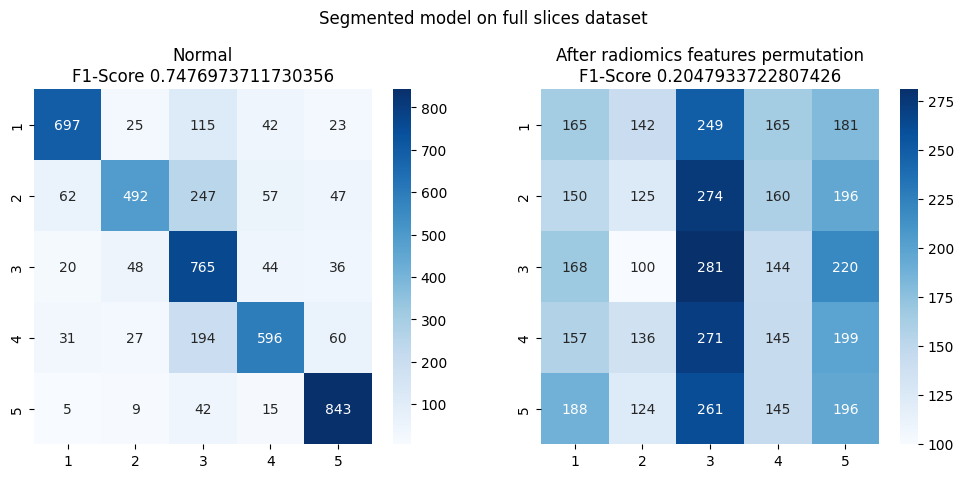

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Segmented model on full slices dataset")
plt.subplots_adjust(top=0.82)
for ax, preds, title in zip(axs.flat, [before_preds, after_preds], ["Normal", "After radiomics features permutation"]):
    preds = np.argmax(preds, axis=-1)
    ax.set_title(f"{title}\nF1-Score {f1_score(preds, true_classes, average='weighted')}")
    plot_confusion_matrix(ax, preds, true_classes)

Let's do the same for the other model

In [15]:
# Before
before_preds = full_slice_model.predict([full_slices, radiomics_features_PCA])
# After
after_preds = full_slice_model.predict([full_slices, permutated_features])

142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step


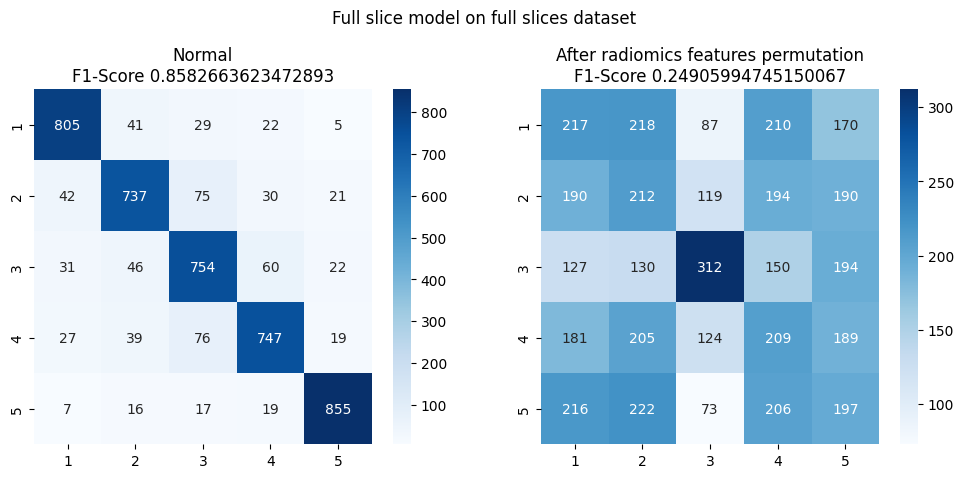

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Full slice model on full slices dataset")
plt.subplots_adjust(top=0.82)
for ax, preds, title in zip(axs.flat, [before_preds, after_preds], ["Normal", "After radiomics features permutation"]):
    preds = np.argmax(preds, axis=-1)
    ax.set_title(f"{title}\nF1-Score {f1_score(preds, true_classes, average='weighted')}")
    plot_confusion_matrix(ax, preds, true_classes)

They radiomics features are clearly very important for making accurate predictions. Let's check whether they are more or less important than the images

In [17]:
permutated_images = np.random.permutation(full_slices)

# Before
before_preds = segmented_model.predict([full_slices, radiomics_features_PCA])
# After
after_preds = segmented_model.predict([permutated_images, radiomics_features_PCA])

142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step


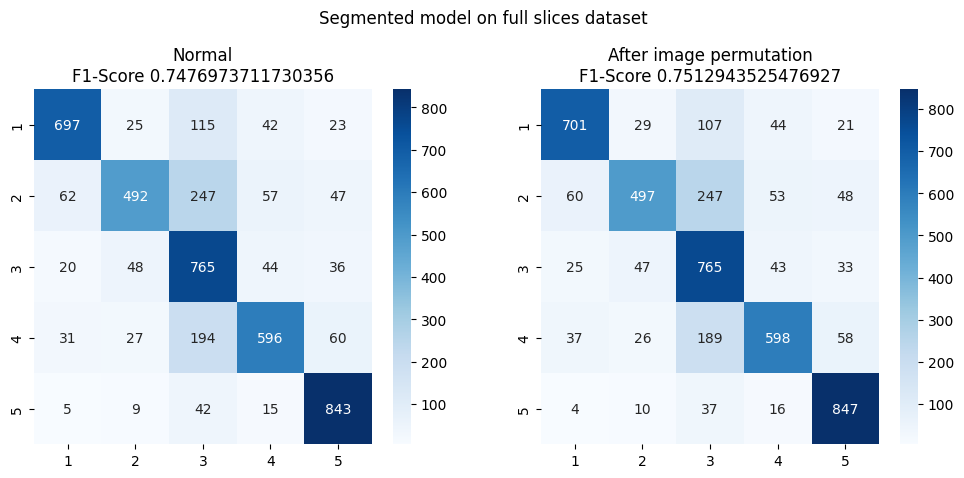

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Segmented model on full slices dataset")
plt.subplots_adjust(top=0.82)
for ax, preds, title in zip(axs.flat, [before_preds, after_preds], ["Normal", "After image permutation"]):
    preds = np.argmax(preds, axis=-1)
    ax.set_title(f"{title}\nF1-Score {f1_score(preds, true_classes, average='weighted')}")
    plot_confusion_matrix(ax, preds, true_classes)

and again on the other model

In [19]:
# Before
before_preds = full_slice_model.predict([full_slices, radiomics_features_PCA])
# After
after_preds = full_slice_model.predict([permutated_images, radiomics_features_PCA])

142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step


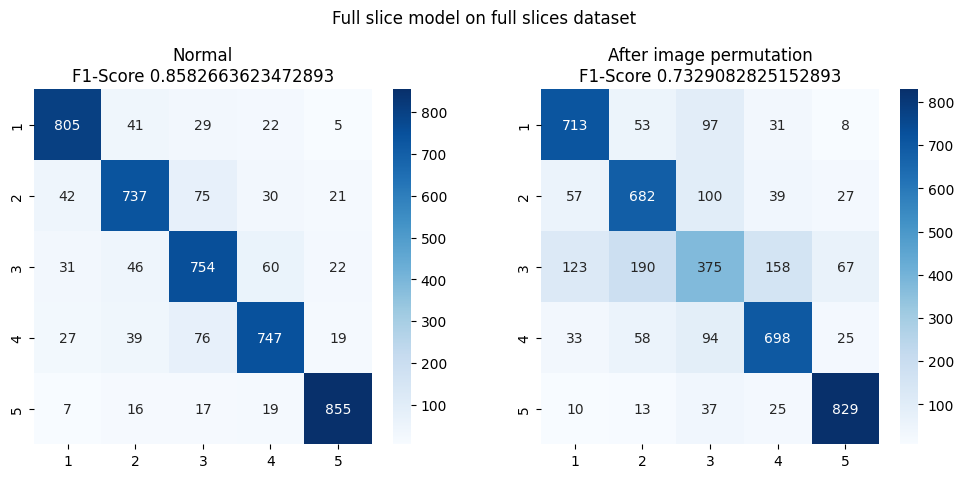

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Full slice model on full slices dataset")
plt.subplots_adjust(top=0.82)
for ax, preds, title in zip(axs.flat, [before_preds, after_preds], ["Normal", "After image permutation"]):
    preds = np.argmax(preds, axis=-1)
    ax.set_title(f"{title}\nF1-Score {f1_score(preds, true_classes, average='weighted')}")
    plot_confusion_matrix(ax, preds, true_classes)

The images are clearly not as important as the radiomics features. The model, most of the time, doesn't care that much about the images which should be the most important thing to consider for this problem. We say "most of the time" because by looking at CAMs we can see that sometimes the class activation map actually corresponds to the nodule location and therefore, for that particular instance, the image has some importance.

In [21]:
del permutated_images

## Bootstrapping confidence intervals by unlocking dropout layers

In [56]:
predictions = []
TEST_IDX = 1444

# def softmax(x): # why isn't there a numpy function?
#     return np.exp(x)/sum(np.exp(x))

test_image = np.expand_dims(full_slices[TEST_IDX], axis=0)
test_radiomics = np.expand_dims(radiomics_features_PCA[TEST_IDX], axis=0)

print(f"True class: {true_classes[TEST_IDX]+1}")

iterations = 100
bagging_size = 20
for _ in range(iterations):
    bagged_prediction = []
    for __ in range(bagging_size):
        bagged_prediction.append(segmented_model([test_image, test_radiomics], training = True).numpy()[0])
    
    predictions.append(np.mean(bagged_prediction, axis=0)) # quick and dirty "ensembling"

means = np.mean(predictions, axis=0)
std_devs = np.std(predictions, axis=0)

True class: 5


In [57]:
from ridgeplot import ridgeplot

distributions = np.asarray(predictions).T # for actual distributions
# distributions = [ np.random.normal(loc=mu, scale=sigma, size=1000) for mu, sigma in zip(means, std_devs)] # for gaussians estimates

column_names = [
    "Severity class 1",
    "Severity class 2",
    "Severity class 3",
    "Severity class 4",
    "Severity class 5",
]

fig = ridgeplot(
    samples=distributions, 
    nbins=25,
    labels=column_names,
    colorscale="viridis",
    colormode="row-index",
    line_width=0,
    opacity=0.8
)

fig.update_layout(
    yaxis_title=dict(text="Probability density", font_size=18),
    xaxis_title=dict(text="Predicted probability", font_size=18),
    title= f"Distribution of {bagging_size}-bagged model's output probabilities for image {TEST_IDX}, true class {true_classes[TEST_IDX]+1}"
)

fig.show()